# Determining the Spread of Epidemics

Alberto Chimenti - 1210360

In [1]:
import numpy as np
#import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
#from tqdm import tqdm  #Library for update bar

%matplotlib inline
%precision 4

'%.4f'

In [3]:
from numba import jit
from tqdm import tqdm

In [4]:
def SIS(adj): 
    G=nx.Graph(adj)
    k=np.asarray([G.degree(n) for n in G.nodes()])
    k_1=np.mean(k)
    k_2=np.mean(k**2)
    eig,_=np.linalg.eigh(adj)
    eigval=eig[-1]
    return k_1, k_2, eigval

def crit_vals_SIS(adj, mu):
    k_1, k_2, eig=SIS(adj)
    MF_crit=mu/k_1
    HMF_crit=mu*k_1/k_2
    QMF_crit=mu/eig
    return MF_crit, HMF_crit, QMF_crit

In [5]:
def Gillespie(adj, k, l, mu=0.5, steps=1000):
    N=len(adj)
    #Initialization
    nodes=np.zeros(N, dtype=int)
    infected=np.random.randint(0,N,size=10)
    nodes[[i for i in infected]]=1
    I=np.sum(nodes)
    for i in np.arange(steps):
        
        if I==0:
            return 0
        #elif I==N:      #Useful for high lambdas
        #    return N
        
        a1=I*mu
        a2=I*(N-I)*l*k/(N-1)
    
        r=np.random.rand()
    
        if ((a1+a2)*r)<a1:
            ind=np.random.choice(np.nonzero(nodes)[0]) #Choose random ill individual
            nodes[ind]=0
            I-=1
        else:
            ill=np.nonzero(nodes)[0] #Ill indexes
            susc=np.nonzero(1-nodes)[0] #Susceptible indexes
            linked=np.nonzero(adj[ill,:]) #Indexes of linked ills
            linked=np.intersect1d(linked[1][:], susc)  #Matching links with susceptibles
            rind=np.random.choice(linked) #Choose random susceptible among the selected ones
            nodes[rind]=1
            I+=1
    return I

def SIS_gillespie(adj, k, l, n_samples, mu=0.5, steps=1000):
    I=np.zeros(n_samples)
    for i in np.arange(n_samples):
        I[i]=Gillespie(adj, k, l, mu=mu, steps=steps) 
   
    return I, np.std(I)

In [6]:
def phase_transition(adj,k,lmbds, n_samples=100, steps=2000, verb=10):
    I=np.zeros((len(lmbds), n_samples))
    std=np.zeros(len(lmbds))
    for i,l in enumerate(lmbds):
        print(i, end='\t')
        I[i,:], std[i]=SIS_gillespie(adj, k, l, n_samples, steps=steps)
        if i%verb==0:
            print('\n-->|'+str(i)+'| lambda:'+str(l)+'\t infected:', np.mean(I[i,:]),'\t std:', std[i])

    #Check compatibility of zeros
    I_mean=np.mean(I, axis=1)
    n_zeros=np.nonzero(I_mean)[0]
    mask=[(I_mean[n_zeros]-std[n_zeros])<=0]
    l=lmbds[n_zeros[mask]]
    
    return I, std, I_mean, l[-1]
    

In [7]:
def graph_prop(G):
    betwc = np.array(list(nx.betweenness_centrality(G).values()))
    deg = np.asarray([G.degree(n) for n in G.nodes()])
    clust = np.array(list(nx.clustering(G).values()))
    pager = np.array(list(nx.pagerank(G).values()))
    return deg, clust, betwc, pager

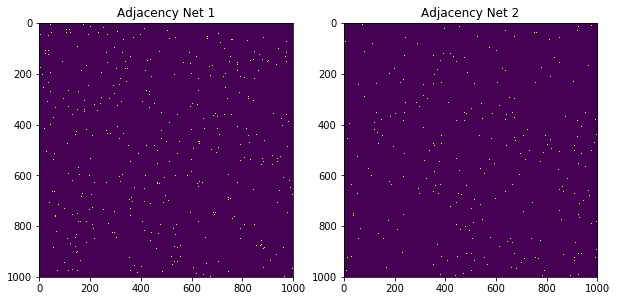

In [8]:
edge1=np.loadtxt('net1.txt', dtype=int)
edge2=np.loadtxt('net2.txt', dtype=int)
adj1=np.zeros((np.max(edge1)+1,np.max(edge1)+1), dtype=int)
adj2=np.zeros((np.max(edge2)+1,np.max(edge2)+1), dtype=int)
for i in np.arange(len(edge1)):
    adj1[edge1[i,0], edge1[i,1]]=1
    adj1[edge1[i,1], edge1[i,0]]=1
for i in np.arange(len(edge2)):
    adj2[edge2[i,0], edge2[i,1]]=1
    adj2[edge2[i,1], edge2[i,0]]=1
    
#Visualization
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].imshow(adj1)
ax[0].set_title('Adjacency Net 1')
ax[1].imshow(adj2)
ax[1].set_title('Adjacency Net 2')
plt.savefig('images/adj_net.png')
plt.show()

# 1. Theoretical SIS

In [9]:
mu=0.5
MF_1, HMF_1, QMF_1=crit_vals_SIS(adj1, mu)
MF_2, HMF_2, QMF_2=crit_vals_SIS(adj2, mu)
print('SIS model results:\n')
print('MF_1 critical value', MF_1)
print('HMF_1 critical value', HMF_1)
print('QMF_1 critical value', QMF_1)
print('---------------------')
print('MF_2 critical value', MF_2)
print('HMF_2 critical value', HMF_2)
print('QMF_2 critical value', QMF_2)

SIS model results:

MF_1 critical value 0.0971628449280995
HMF_1 critical value 0.08160482080558198
QMF_1 critical value 0.07956585298798922
---------------------
MF_2 critical value 0.13919821826280623
HMF_2 critical value 0.07587663709336713
QMF_2 critical value 0.0663995969724411


# 2. SIS Simulation (well-mixed Gillespie)

In [10]:
k1,_,_=SIS(adj1)
k2,_,_=SIS(adj2)

n_samples=50
steps=2000
np.random.seed(1234789)

In [11]:
#First network
lmbds1=np.linspace(0.08,0.15, 21)
#lmbds1=np.linspace(0.09,0.13, 21)

print('Network 1')
I1,std1, I1_mean, l_c1=phase_transition(adj1,k1,lmbds1, n_samples=n_samples, steps=steps, verb=10)


#Second network
lmbds2=np.linspace(0.122,0.192, 21)
#lmbds2=np.linspace(0.09,0.13, 21)

print('\nNetwork 2')
I2,std2,I2_mean,l_c2=phase_transition(adj2,k2,lmbds2, n_samples=n_samples, steps=steps, verb=10)

#Reascale
I1_mean/=len(adj1)
I2_mean/=len(adj2)

std1/=len(adj1)
std2/=len(adj2)

Network 1
0	
-->|0| lambda:0.08	 infected: 0.0 	 std: 0.0
1	2	3	4	5	6	7	8	9	10	
-->|10| lambda:0.11499999999999999	 infected: 101.6 	 std: 41.7262507302058
11	12	13	14	15	16	17	18	19	20	
-->|20| lambda:0.15	 infected: 264.34 	 std: 31.90586779888615

Network 2
0	
-->|0| lambda:0.122	 infected: 0.0 	 std: 0.0
1	2	3	4	5	6	7	8	9	10	
-->|10| lambda:0.157	 infected: 50.84 	 std: 46.53272396926705
11	12	13	14	15	16	17	18	19	20	
-->|20| lambda:0.192	 infected: 199.58 	 std: 40.12086240349277


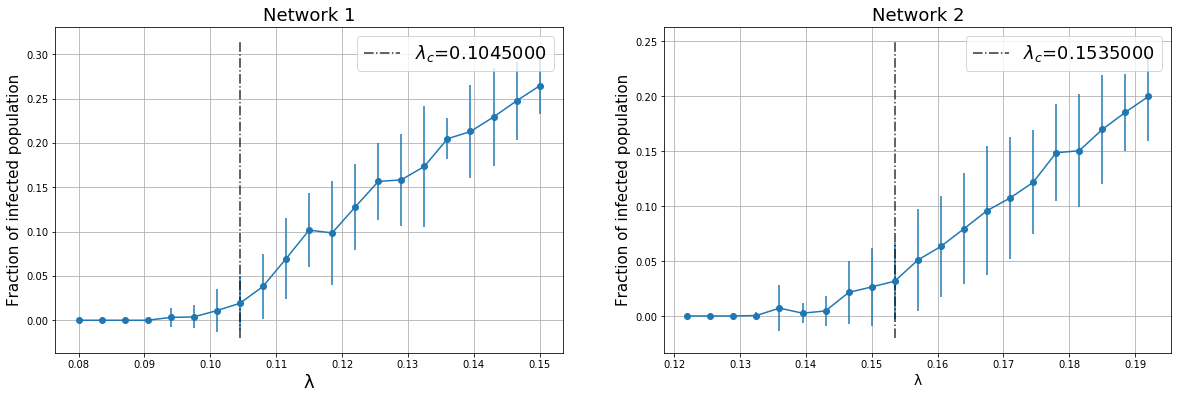

In [12]:
#Visualize
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(20,6))
ax[0].errorbar(lmbds1,I1_mean, yerr=std1, marker='o')
ax[0].set_title('Network 1', fontsize=18)
ax[0].vlines(l_c1,np.min(I1_mean)-0.02,np.max(I1_mean)+0.05, linestyles='dashdot', label=('$λ_c$=%.7f'%l_c1), alpha=0.8)
ax[0].set_xlabel('λ', fontsize=18)
ax[0].set_ylabel('Fraction of infected population', fontsize=15)
ax[0].legend(fontsize=18)
ax[0].grid()
ax[1].errorbar(lmbds2,I2_mean, yerr=std2, marker='o')
ax[1].set_title('Network 2', fontsize=18)
ax[1].vlines(l_c2,np.min(I2_mean)-0.02,np.max(I2_mean)+0.05, linestyles='dashdot', label=('$λ_c$=%.7f'%l_c2), alpha=0.8)
ax[1].set_xlabel('λ', fontsize=14)
ax[1].set_ylabel('Fraction of infected population', fontsize=15)
ax[1].legend(fontsize=18)
ax[1].grid()
string=('steps'+str(steps)+'_samp'+str(n_samples)+'_range('+str(min(lmbds1))+','+str(min(lmbds2))+')_('+str(max(lmbds1))+','+str(max(lmbds2))+')_'+str(len(lmbds1)))
plt.savefig('images/'+str(string)+'.png')
plt.show()

# 3. Network Characterization

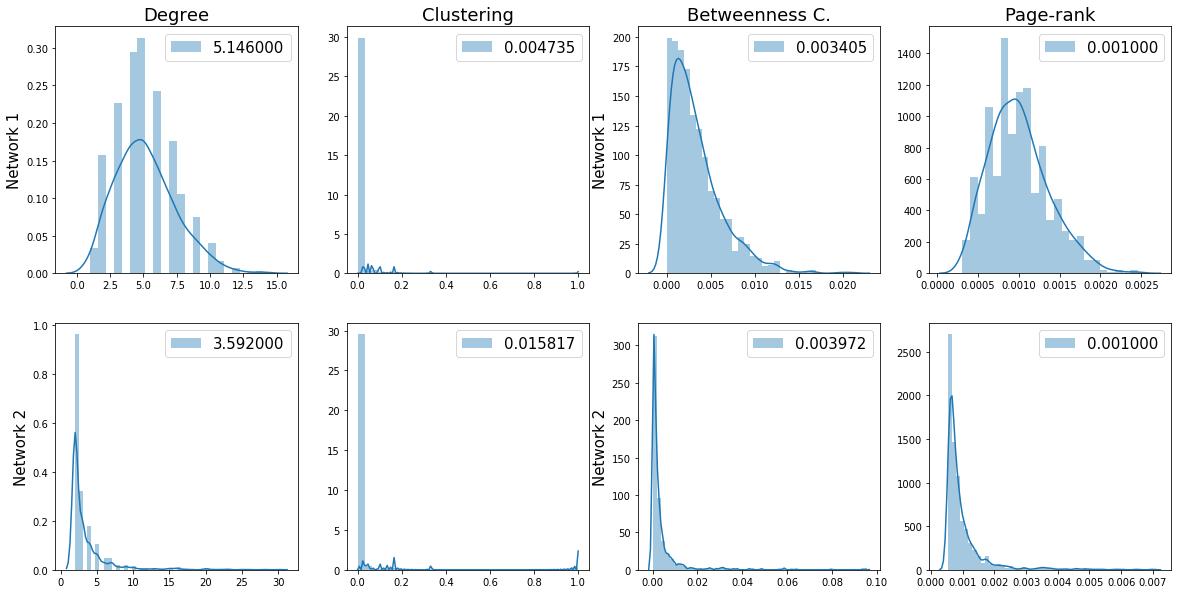

In [18]:
G1=nx.Graph(adj1)
G2=nx.Graph(adj2)

deg1, clust1, betwc1, pager1 = graph_prop(G1)
deg2, clust2, betwc2, pager2 = graph_prop(G2)

fig, ax=plt.subplots(nrows=2, ncols=4, figsize=(20,10))
ax[0,0].set_title('Degree', fontsize=18)
ax[0,1].set_title('Clustering', fontsize=18)
ax[0,2].set_title('Betweenness C.', fontsize=18)
ax[0,3].set_title('Page-rank', fontsize=18)
ax[0,0].set_ylabel('Network 1', fontsize=15)
ax[1,0].set_ylabel('Network 2', fontsize=15)
ax[0,2].set_ylabel('Network 1', fontsize=15)
ax[1,2].set_ylabel('Network 2', fontsize=15)
sns.distplot(deg1, ax=ax[0,0], label=('%.6f' %np.mean(deg1)))
sns.distplot(clust1, ax=ax[0,1], label=('%.6f'%np.mean(clust1)))
sns.distplot(betwc1, ax=ax[0,2], label=('%.6f'%np.mean(betwc1)))
sns.distplot(pager1, ax=ax[0,3], label=('%.6f'%np.mean(pager1)))
sns.distplot(deg2, ax=ax[1,0], label=('%.6f'%np.mean(deg2)))
sns.distplot(clust2, ax=ax[1,1], label=('%.6f'%np.mean(clust2)))
sns.distplot(betwc2, ax=ax[1,2], label=('%.6f'%np.mean(betwc2)))
sns.distplot(pager2, ax=ax[1,3], label=('%.6f'%np.mean(pager2)))
ax[0,0].legend(fontsize=15)
ax[0,1].legend(fontsize=15)
ax[0,2].legend(fontsize=15)
ax[0,3].legend(fontsize=15)
ax[1,0].legend(fontsize=15)
ax[1,1].legend(fontsize=15)
ax[1,2].legend(fontsize=15)
ax[1,3].legend(fontsize=15)
plt.savefig('images/graph_dist.png')
plt.show()

# 4. Segregation

In [14]:
#Network 1
c_indexes=np.argsort(deg1)[989:999] #Indexes of 30% nodes with maximum degree
G1.remove_nodes_from(c_indexes)
print(np.size(G1.nodes))

k1=np.mean(np.asarray([G1.degree(n) for n in G1.nodes()]))
n_adj1=nx.to_numpy_matrix(G1)

print('Network 1')
I1_n,std1_n, I1_mean_n, l_c1_n=phase_transition(n_adj1,k1,lmbds1, n_samples=n_samples, steps=steps, verb=10)

#Network 2
k_indexes=np.argsort(deg2)[989:999] #Indexes of 30% nodes with maximum degree
G2.remove_nodes_from(k_indexes)
print(np.size(G2.nodes))

k2=np.mean(np.asarray([G2.degree(n) for n in G2.nodes()]))
n_adj2=nx.to_numpy_matrix(G2)

print('\nNetwork 2')
I2_n,std2_n,I2_mean_n,l_c2_n=phase_transition(n_adj2,k2,lmbds2, n_samples=n_samples, steps=steps, verb=10)

#Reascale
I1_mean_n/=len(n_adj1)
I2_mean_n/=len(n_adj2)
std1_n/=len(n_adj1)
std2_n/=len(n_adj2)

990
Network 1
0	
-->|0| lambda:0.08	 infected: 0.0 	 std: 0.0
1	2	3	4	5	6	7	8	9	10	
-->|10| lambda:0.11499999999999999	 infected: 55.26 	 std: 48.977876638335395
11	12	13	14	15	16	17	18	19	20	
-->|20| lambda:0.15	 infected: 249.44 	 std: 30.74876257672819
990

Network 2
0	
-->|0| lambda:0.122	 infected: 0.0 	 std: 0.0
1	2	3	4	5	6	7	8	9	10	
-->|10| lambda:0.157	 infected: 3.88 	 std: 11.008433131013694
11	12	13	14	15	16	17	18	19	20	
-->|20| lambda:0.192	 infected: 109.94 	 std: 48.91560487206511


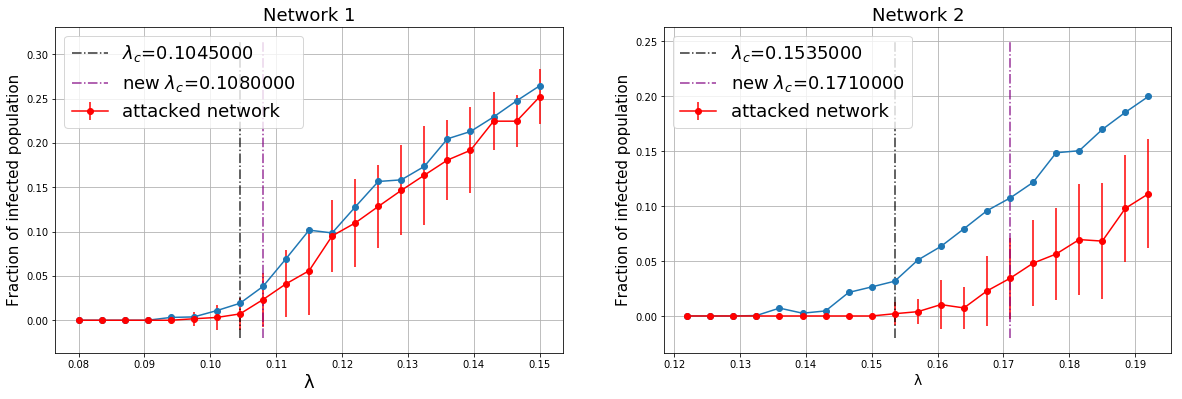

In [15]:
#Visualize
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(20,6))
ax[0].plot(lmbds1,I1_mean, marker='o')
ax[0].errorbar(lmbds1,I1_mean_n, yerr=std1_n, marker='o', color='red', label='attacked network')
ax[0].set_title('Network 1', fontsize=18)
ax[0].vlines(l_c1,np.min(I1_mean)-0.02,np.max(I1_mean)+0.05, linestyles='dashdot', label=('$λ_c$=%.7f'%l_c1), alpha=0.8)
ax[0].vlines(l_c1_n,np.min(I1_mean)-0.02,np.max(I1_mean)+0.05, linestyles='dashdot', label=('new $λ_c$=%.7f'%l_c1_n), color='purple', alpha=0.8)
ax[0].set_xlabel('λ', fontsize=18)
ax[0].set_ylabel('Fraction of infected population', fontsize=15)
ax[1].plot(lmbds2,I2_mean, marker='o')
ax[1].errorbar(lmbds2,I2_mean_n, yerr=std2_n, marker='o', color='red', label='attacked network')
ax[1].set_title('Network 2', fontsize=18)
ax[1].vlines(l_c2,np.min(I2_mean)-0.02,np.max(I2_mean)+0.05, linestyles='dashdot', label=('$λ_c$=%.7f'%l_c2), alpha=0.8)
ax[1].vlines(l_c2_n,np.min(I2_mean)-0.02,np.max(I2_mean)+0.05, linestyles='dashdot', label=('new $λ_c$=%.7f'%l_c2_n), color='purple', alpha=0.8)
ax[1].set_xlabel('λ', fontsize=14)
ax[1].set_ylabel('Fraction of infected population', fontsize=15)
ax[0].legend(fontsize=18)
ax[1].legend(fontsize=18)
ax[0].grid()
ax[1].grid()
string=('steps'+str(steps)+'_samp'+str(n_samples)+'_range('+str(min(lmbds1))+','+str(min(lmbds2))+')_('+str(max(lmbds1))+','+str(max(lmbds2))+')_'+str(len(lmbds1)))
plt.savefig('images/n_'+str(string)+'.png')
plt.show()

# 5. Chicken Pox

Estimated β = 0.07507346089734118 +/- 0.002604044987051965
Estimated γ = 0.00971910766594186 +/- 0.0007627979098948382
Estimated R0 = 7.771564124968369 +/- 0.6655055218325029


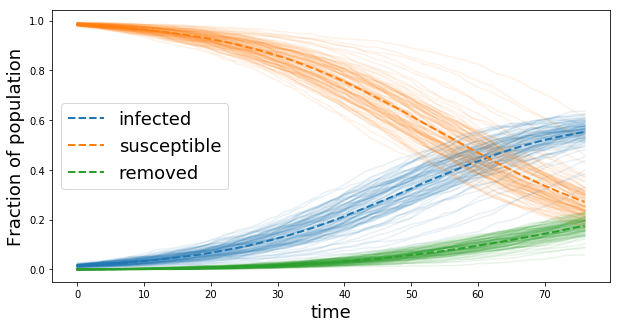

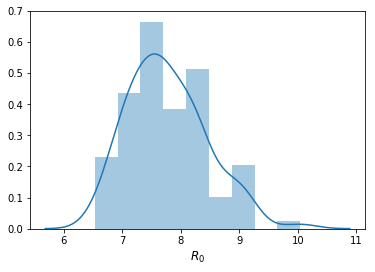

In [16]:
df = pd.read_csv('cases_100locations_first77days.txt', sep=' ', names=['loc', 'day', 's', 'i', 'r'], skiprows=1)
loc=pd.unique(df['loc'])
  
#Parameters estimation
beta=np.zeros(len(loc))
gamma=np.zeros(len(loc))
for i in loc:
    beta[i-1]=-(df[df['loc']==i]['s'].values[-1]-df[df['loc']==i]['s'].values[0])/(np.sum(df[df['loc']==i]['s']*df[df['loc']==i]['i']))
    gamma[i-1]=df[df['loc']==i]['r'].values[-1]/(np.sum(df[df['loc']==i]['i']))
R_0=beta/gamma

print('Estimated β = '+str(np.mean(beta))+' +/- '+str(np.std(beta)))
print('Estimated γ = '+str(np.mean(gamma))+' +/- '+str(np.std(gamma)))
print('Estimated R0 = '+str(np.mean(R_0))+' +/- '+str(np.std(R_0)))

#Mean i,s,r
d_mean=df.groupby('day').mean()

#Visualization
fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10,5))
for i in loc:
    ax.plot(df[df['loc']==i]['day'].values, df[df['loc']==i]['i'].values, alpha=0.1, color='C0')
    ax.plot(df[df['loc']==i]['day'].values, df[df['loc']==i]['s'].values, alpha=0.1, color='C1')
    ax.plot(df[df['loc']==i]['day'].values, df[df['loc']==i]['r'].values, alpha=0.1, color='C2')    
#ax[0].set_xlabel('time', fontsize=18)
#ax[0].set_ylabel('Fraction of infected population', fontsize=18)

ax.plot(d_mean.index.values, d_mean['i'].values, label='infected', color='C0', linewidth=2, linestyle='--')
ax.plot(d_mean.index.values, d_mean['s'].values, label='susceptible',color='C1', linewidth=2, linestyle='--')
ax.plot(d_mean.index.values, d_mean['r'].values, label='removed', color='C2', linewidth=2, linestyle='--')
ax.set_xlabel('time', fontsize=18)
ax.set_ylabel('Fraction of population', fontsize=18)
ax.legend(fontsize=18)
plt.savefig('images/pop_frac_time.png')
plt.show()

fig=plt.figure(); ax=plt.axes()
sns.distplot(R_0, ax=ax)
ax.set_xlabel('$R_0$', fontsize=12)
plt.savefig('images/R_0_dist.png')
plt.show()